In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya
from malaya.torch_model.t5 import T5Diaparser
from transformers import T5Tokenizer, T5Config

In [3]:
tokenizer_ = malaya.tokenizer.Tokenizer()

In [4]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('mesolitica/t5-small-standard-bahasa-cased')

In [6]:
from glob import glob

checkpoints = sorted(glob('finetune-t5-small-standard-bahasa-cased-v2/checkpoint-*'))
checkpoints

['finetune-t5-small-standard-bahasa-cased-v2/checkpoint-2060000',
 'finetune-t5-small-standard-bahasa-cased-v2/checkpoint-2070000',
 'finetune-t5-small-standard-bahasa-cased-v2/checkpoint-2080000']

In [7]:
# !cp -r finetune-t5-small-standard-bahasa-cased checkpoint

In [8]:
model = T5Diaparser.from_pretrained(checkpoints[-1])

In [9]:
text = 'Dr Mahathir menasihati mereka supaya berhenti berehat dan tidur sebentar sekiranya mengantuk ketika memandu.'
text = tokenizer_.tokenize(text)

In [10]:
s = """
KUALA LUMPUR: Dalam hal politik, jarang sekali untuk melihat dua figura ini - bekas Perdana Menteri, Datuk Seri Najib Razak dan Tun Dr Mahathir Mohamad mempunyai 'pandangan yang sama' atau sekapal. Namun, situasi itu berbeza apabila melibatkan isu ketidakpatuhan terhadap prosedur operasi standard (SOP). Najib, yang juga Ahli Parlimen Pekan memuji sikap Ahli Parlimen Langkawi itu yang mengaku bersalah selepas melanggar SOP kerana tidak mengambil suhu badan ketika masuk ke sebuah surau di Langkawi pada Sabtu lalu.
"""
text = tokenizer_.tokenize(s)

In [11]:
# text = 'saya tak suka ayam dan daging.'
# text = tokenizer_.tokenize(text)

In [12]:
texts, indices = [1], [0]
for i in range(len(text)):
    t = tokenizer.encode(text[i], add_special_tokens=False)
    texts.extend(t)
    indices.extend([i + 1] * len(t))

In [13]:
model_inputs = {
    'input_ids': texts,
    'attention_mask': [1] * len(texts),
    'indices': indices
}
padded = tokenizer.pad(
    [model_inputs],
    padding=True,
    max_length=None,
    pad_to_multiple_of=None,
    return_tensors='pt',
)

In [14]:
padded = tokenizer.pad(
    [model_inputs],
    padding=True,
    max_length=None,
    pad_to_multiple_of=None,
    return_tensors='pt',
)

In [15]:
padded

{'input_ids': tensor([[    1,  2147,  2377,    13,    31,   335,  1553,   486,    13,    14,
          3842,   793,    25,   244,   192,    13, 14656,    83,    34,    13,
             7,   821,  1188,   506,    13,    14,   390,   738,  2562,  3993,
            22,  1459,   267,  1334,  1631,   118,    13,    12,  2097,    17,
           200,    12,    87,  1210, 17300,    13,     3,   918,    13,    14,
          4381,    37,   936,   721,  2077,   665, 11452,   942, 14811,   226,
          7162,  1436,  2022,    13,     4,    13, 17098,    13,     5,    13,
             3,  2562,    13,    14,    17,    93,  2171,  2174,  9187,  6569,
          4876,  2171,  2174, 11619,    37,    17,  3857,  3465,   428,  4253,
            13, 17098,   122,    30,   330,  6587,  1294,   123,   605,    55,
           136, 19126,    24, 11619,    33,  1686,   186,    13,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1

In [16]:
o = model(**padded)

In [17]:
o.keys()

odict_keys(['logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states', 's_arc', 's_rel'])

In [18]:
arc_preds = o.s_arc.argmax(axis = -1)
rel_preds = o.s_rel.argmax(-1)
rel_preds = rel_preds.gather(-1, arc_preds.unsqueeze(-1)).squeeze(-1)

In [19]:
tag2idx = {'PAD': 0,
 'X': 1,
 'nsubj': 2,
 'cop': 3,
 'det': 4,
 'root': 5,
 'nsubj:pass': 6,
 'acl': 7,
 'case': 8,
 'obl': 9,
 'flat': 10,
 'punct': 11,
 'appos': 12,
 'amod': 13,
 'compound': 14,
 'advmod': 15,
 'cc': 16,
 'obj': 17,
 'conj': 18,
 'mark': 19,
 'advcl': 20,
 'nmod': 21,
 'nummod': 22,
 'dep': 23,
 'xcomp': 24,
 'ccomp': 25,
 'parataxis': 26,
 'compound:plur': 27,
 'fixed': 28,
 'aux': 29,
 'csubj': 30,
 'iobj': 31,
 'csubj:pass': 32}

idx2tag = {v: k for k, v in tag2idx.items()}

In [20]:
from malaya_boilerplate.torch_utils import to_tensor_cuda, to_numpy

In [21]:
seq = padded['input_ids'][0,1:]
seq = tokenizer.convert_ids_to_tokens(seq)
tagging = rel_preds[0,1:].detach().numpy()
depend = arc_preds[0,1:].detach().numpy()
tagging = [idx2tag[i] for i in tagging]

In [22]:
def merge_sentencepiece_tokens_tagging(x, y, model='bert', rejected=None, **kwargs):
    new_paired_tokens = []
    n_tokens = len(x)
    if rejected is None:
        rejected = list(SPECIAL_TOKENS[model].values())

    i = 0

    while i < n_tokens:

        current_token, current_label = x[i], y[i]

        if isinstance(current_token, bytes):
            current_token = current_token.decode()
        if not current_token.startswith('▁') and current_token not in rejected and i > 0:
            previous_token, previous_label = new_paired_tokens.pop()
            merged_token = previous_token
            merged_label = [previous_label]
            while (
                not current_token.startswith('▁')
                and current_token not in rejected
            ):
                merged_token = merged_token + current_token.replace('▁', '')
                merged_label.append(current_label)
                i = i + 1
                if i < n_tokens:
                    current_token, current_label = x[i], y[i]
                else:
                    break
            merged_label = merged_label[0]
            new_paired_tokens.append((merged_token, merged_label))

        else:
            new_paired_tokens.append((current_token, current_label))
            i = i + 1

    words = [
        i[0].replace('▁', '') for i in new_paired_tokens if i[0] not in rejected
    ]
    labels = [i[1] for i in new_paired_tokens if i[0] not in rejected]
    return words, labels


In [23]:
# merge_sentencepiece_tokens_tagging(seq, tagging, rejected = tokenizer.all_special_tokens)

In [24]:
# merge_sentencepiece_tokens_tagging(seq, depend, rejected = tokenizer.all_special_tokens)

In [25]:
from malaya.function.parse_dependency import DependencyGraph

In [26]:
tagging = merge_sentencepiece_tokens_tagging(seq, tagging, rejected = tokenizer.all_special_tokens)
tagging = list(zip(*tagging))
indexing = merge_sentencepiece_tokens_tagging(seq, depend, rejected = tokenizer.all_special_tokens)
indexing = list(zip(*indexing))

result, indexing_ = [], []
for i in range(len(tagging)):
    index = int(indexing[i][1])
    if index > len(tagging):
        index = len(tagging)
    elif (i + 1) == index:
        index = index + 1
    elif index == -1:
        index = i
    indexing_.append((indexing[i][0], index))
    result.append(
        '%d\t%s\t_\t_\t_\t_\t%d\t%s\t_\t_'
        % (i + 1, tagging[i][0], index, tagging[i][1])
    )
d = DependencyGraph('\n'.join(result), top_relation_label='root')

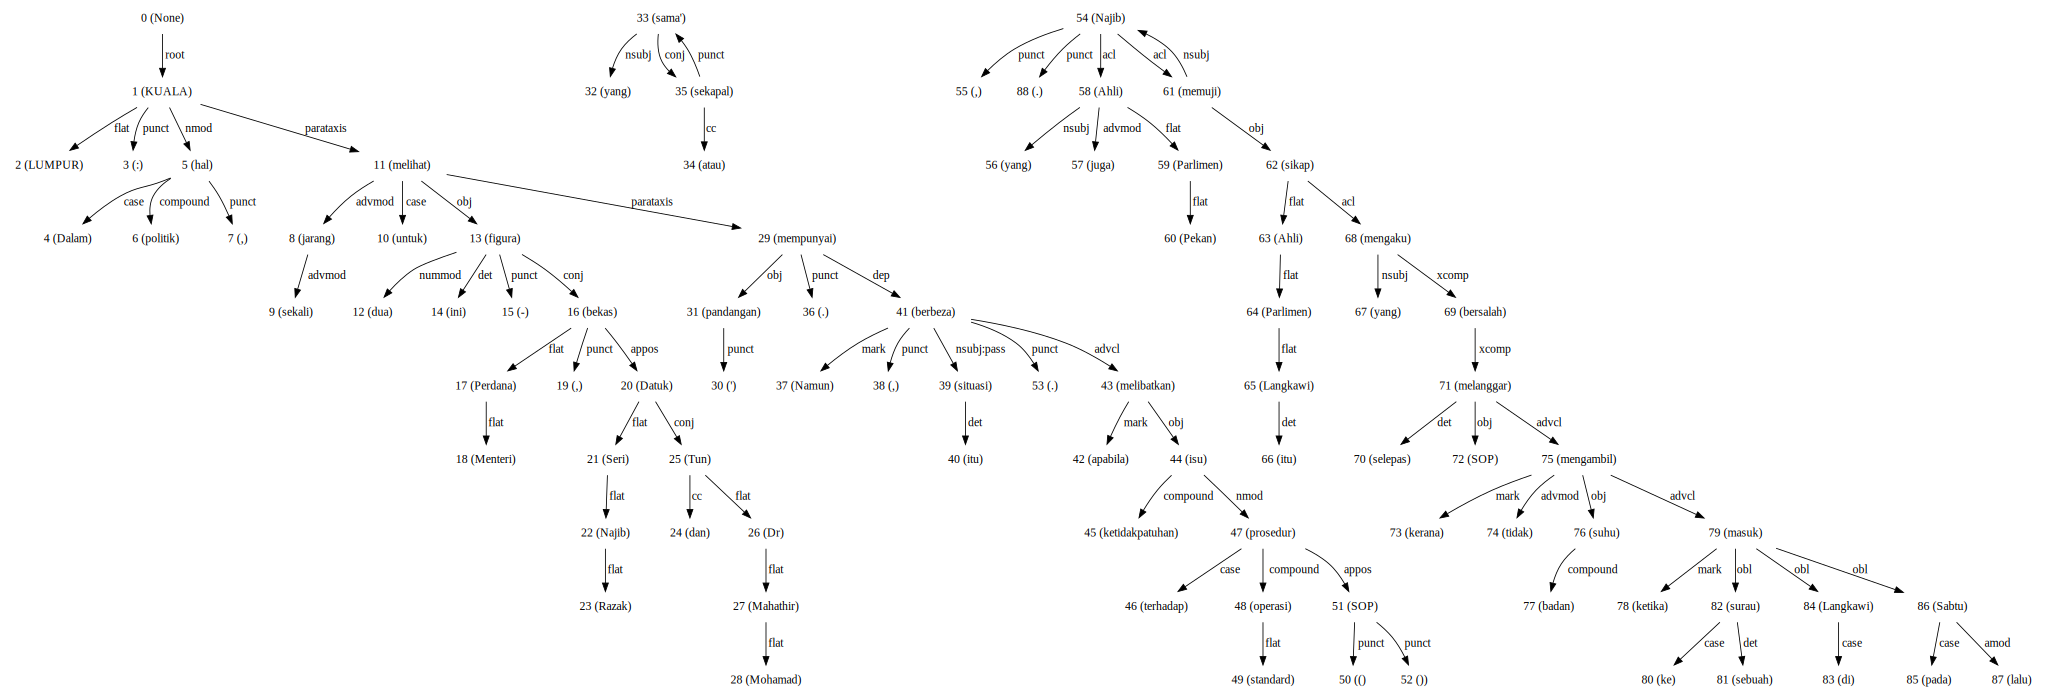

In [27]:
d.to_graphvis()

In [28]:
model.push_to_hub('finetune-dependency-t5-small-standard-bahasa-cased', organization='mesolitica')

CommitInfo(commit_url='https://huggingface.co/mesolitica/finetune-dependency-t5-small-standard-bahasa-cased/commit/440dd11f6d7534a777d3957211efced111a09bd7', commit_message='Upload T5Diaparser', commit_description='', oid='440dd11f6d7534a777d3957211efced111a09bd7', pr_url=None, pr_revision=None, pr_num=None)

In [29]:
tokenizer.push_to_hub('finetune-dependency-t5-small-standard-bahasa-cased', organization='mesolitica')

CommitInfo(commit_url='https://huggingface.co/mesolitica/finetune-dependency-t5-small-standard-bahasa-cased/commit/d55eeb7dc4b205d4e7635619da418990fd33b2b3', commit_message='Upload tokenizer', commit_description='', oid='d55eeb7dc4b205d4e7635619da418990fd33b2b3', pr_url=None, pr_revision=None, pr_num=None)

In [30]:
# !wget https://raw.githubusercontent.com/huseinzol05/malay-dataset/master/parsing/dependency/gsd-ud-test.conllu.txt

In [31]:
groups, temp = [], []
with open('gsd-ud-test.conllu.txt') as fopen:
    for l in fopen:
        l = l.strip()
        if not len(l):
            groups.append(temp[2:])
            temp = []
        else:
            temp.append(l)

In [32]:
from unidecode import unidecode

def get_train(group):
    texts, arcs, tags, indices = [], [], [], []
    for g in group:
        splitted = g.split('\t')
        texts.append(unidecode(splitted[1]).strip())
        arcs.append(int(splitted[6]))
        tags.append(tag2idx[splitted[7]])
        indices.append(int(splitted[0]))
        
    return texts, arcs, tags, indices

In [33]:
def evaluate(heads_pred, types_pred, heads, types, lengths,
             symbolic_root=False, symbolic_end=False):
    batch_size, _ = heads_pred.shape
    ucorr = 0.
    lcorr = 0.
    total = 0.
    ucomplete_match = 0.
    lcomplete_match = 0.

    corr_root = 0.
    total_root = 0.
    start = 1 if symbolic_root else 0
    end = 1 if symbolic_end else 0
    for i in range(batch_size):
        ucm = 1.
        lcm = 1.
        for j in range(start, lengths[i] - end):

            total += 1
            if heads[i, j] == heads_pred[i, j]:
                ucorr += 1
                if types[i, j] == types_pred[i, j]:
                    lcorr += 1
                else:
                    lcm = 0
            else:
                ucm = 0
                lcm = 0

            if heads[i, j] == 0:
                total_root += 1
                corr_root += 1 if heads_pred[i, j] == 0 else 0

        ucomplete_match += ucm
        lcomplete_match += lcm
    
    return ucorr / total, lcorr / total, corr_root / total_root

In [34]:
import numpy as np

In [35]:
x = get_train(groups[0])

texts, indices = [1], [0]
for i in range(len(x[0])):
    t = tokenizer.encode(x[0][i], add_special_tokens=False)
    texts.extend(t)
    indices.extend([i + 1] * len(t))
    
model_inputs = {
    'input_ids': texts,
    'attention_mask': [1] * len(texts),
    'indices': indices
}
padded = tokenizer.pad(
    [model_inputs],
    padding=True,
    max_length=None,
    pad_to_multiple_of=None,
    return_tensors='pt',
)

o = model(**padded)
arc_preds = o.s_arc.argmax(axis = -1)
rel_preds = o.s_rel.argmax(-1)
rel_preds = rel_preds.gather(-1, arc_preds.unsqueeze(-1)).squeeze(-1)
seq = padded['input_ids'][0,1:]
seq = tokenizer.convert_ids_to_tokens(seq)
tagging = rel_preds[0,1:].detach().numpy()
depend = arc_preds[0,1:].detach().numpy()
tagging = merge_sentencepiece_tokens_tagging(seq, tagging, rejected = tokenizer.all_special_tokens)[1]
indexing = merge_sentencepiece_tokens_tagging(seq, depend, rejected = tokenizer.all_special_tokens)[1]

arc_accuracy, type_accuracy, root_accuracy = evaluate(np.expand_dims(np.array(indexing), 0), 
        np.expand_dims(np.array(tagging), 0),
        np.expand_dims(np.array(x[1]), 0),
        np.expand_dims(np.array(x[2]), 0),
        [len(tagging)])

arc_accuracy, type_accuracy, root_accuracy

(0.9152542372881356, 0.8135593220338984, 1.0)

In [36]:
from tqdm import tqdm

arcs, types, roots = [], [], []

for n in tqdm(range(len(groups))):
    x = get_train(groups[n])

    texts, indices = [1], [0]
    for i in range(len(x[0])):
        t = tokenizer.encode(x[0][i], add_special_tokens=False)
        texts.extend(t)
        indices.extend([i + 1] * len(t))

    model_inputs = {
        'input_ids': texts,
        'attention_mask': [1] * len(texts),
        'indices': indices
    }
    padded = tokenizer.pad(
        [model_inputs],
        padding=True,
        max_length=None,
        pad_to_multiple_of=None,
        return_tensors='pt',
    )

    o = model(**padded)
    arc_preds = o.s_arc.argmax(axis = -1)
    rel_preds = o.s_rel.argmax(-1)
    rel_preds = rel_preds.gather(-1, arc_preds.unsqueeze(-1)).squeeze(-1)
    seq = padded['input_ids'][0,1:]
    seq = tokenizer.convert_ids_to_tokens(seq)
    tagging = rel_preds[0,1:].detach().numpy()
    depend = arc_preds[0,1:].detach().numpy()
    tagging = merge_sentencepiece_tokens_tagging(seq, tagging, rejected = tokenizer.all_special_tokens)
    s_tagging = tagging[0]
    tagging = tagging[1]
    indexing = merge_sentencepiece_tokens_tagging(seq, depend, rejected = tokenizer.all_special_tokens)[1]
    
    try:
        arc_accuracy, type_accuracy, root_accuracy = evaluate(np.expand_dims(np.array(indexing), 0), 
                np.expand_dims(np.array(tagging), 0),
                np.expand_dims(np.array(x[1]), 0),
                np.expand_dims(np.array(x[2]), 0),
                [len(tagging)])

        arcs.append(arc_accuracy)
        types.append(type_accuracy)
        roots.append(root_accuracy)
    except Exception as e:
        print(e)

 61%|█████████████████████████                | 341/557 [00:08<00:05, 42.69it/s]

index 48 is out of bounds for axis 1 with size 48


100%|█████████████████████████████████████████| 557/557 [00:14<00:00, 39.28it/s]


In [38]:
np.mean(arcs), np.mean(types), np.mean(roots)

(0.8494045261191319, 0.783103051811978, 0.8669064748201439)